# Generate median joining network artwork and cluster membership

In [1]:
%run setup.ipynb
#%matplotlib inline
# %load_ext autoreload
# %autoreload 1
# %aimport hapclust
import hapclust
# import ag1k

## data setup

In [2]:
# load data
callset_haps = np.load('../data/haps_phase2.npz')
haps = allel.HaplotypeArray(callset_haps['haplotypes'])
pos = allel.SortedIndex(callset_haps['POS'])
# ann = callset_haps['ANN']

In [3]:
start = 2358158
stop = 2431617

In [4]:
# chop into gene
loc_vgsc = pos.locate_range(start, stop)
h_vgsc = haps[loc_vgsc]
pos_vgsc = pos[loc_vgsc]
h_vgsc

<HaplotypeArray shape=(2092, 2284) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [5]:
#load haplotype metadata
df_haplotypes_fn = '../phase2.AR1/haplotypes/haplotypes.autosomes.meta.txt'
df_haplotypes = pd.read_csv(df_haplotypes_fn, sep='\t').query('population != "colony"')
df_haplotypes.head()

,Unnamed: 0,label,ox_code,population,label_aug,country,region,sex,m_s
0,0,AA0040-Ca,AA0040-C,GHcol,"AA0040-Ca [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
1,1,AA0040-Cb,AA0040-C,GHcol,"AA0040-Cb [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
2,2,AA0041-Ca,AA0041-C,GHcol,"AA0041-Ca [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
3,3,AA0041-Cb,AA0041-C,GHcol,"AA0041-Cb [Ghana, Twifo_Praso, M F]",Ghana,Twifo_Praso,F,M
4,4,AA0042-Ca,AA0042-C,GHcol,"AA0042-Ca [Ghana, Takoradi, M F]",Ghana,Takoradi,F,M


In [6]:
assert len(df_haplotypes) == h_vgsc.shape[1]

In [7]:
df_haplotypes.groupby(by=['country', 'population']).count()[['label']]

label
country           population       
Angola            AOcol         156
Burkina Faso      BFcol         150
                  BFgam         184
Cameroon          CMgam         594
Cote d'Ivoire     CIcol         142
Equatorial Guinea GQgam          18
France            FRgam          48
Gabon             GAgam         138
Gambia, The       GM            130
Ghana             GHcol         110
                  GHgam          24
Guinea            GNcol           8
                  GNgam          80
Guinea-Bissau     GW            182
Kenya             KE             96
Uganda            UGgam         224

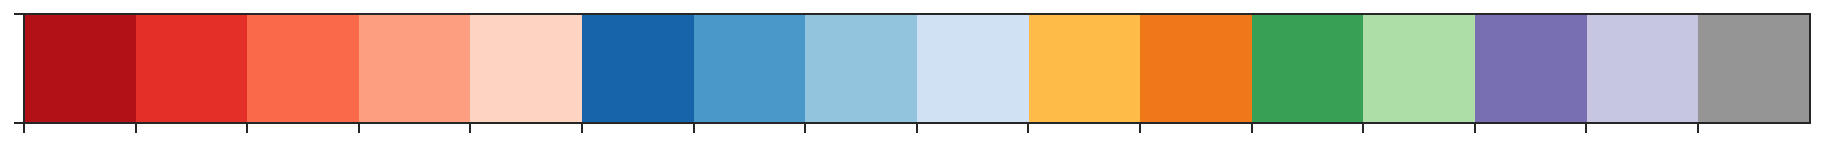

In [8]:
#these colours need to be 'named' for graphviz but I can't see a way of converting them 
sns.palplot(phase2_ar1.pop_colors.values())

In [9]:
phase2_ar1.pop_colors

{'AOcol': (0.6943944636678201, 0.07003460207612457, 0.09231833910034601),
 'GHcol': (0.8901960784313725, 0.18562091503267975, 0.15294117647058825),
 'BFcol': (0.9835755478662053, 0.4127950788158401, 0.28835063437139563),
 'CIcol': (0.9882352941176471, 0.6261437908496732, 0.5084967320261438),
 'GNcol': (0.9935870818915802, 0.8323414071510957, 0.7624913494809689),
 'CMgam': (0.09019607843137256, 0.39294117647058824, 0.6705882352941177),
 'GHgam': (0.2909803921568628, 0.5945098039215686, 0.7890196078431373),
 'BFgam': (0.5796078431372549, 0.7701960784313725, 0.8737254901960784),
 'GNgam': (0.8141176470588235, 0.883921568627451, 0.9498039215686275),
 'GW': (0.996078431372549, 0.7349019607843138, 0.28),
 'GM': (0.939607843137255, 0.4713725490196078, 0.09490196078431372),
 'GAgam': (0.21568627450980393, 0.6287581699346405, 0.3333333333333333),
 'UGgam': (0.681045751633987, 0.8718954248366013, 0.6562091503267974),
 'FRgam': (0.47320261437908495, 0.43267973856209146, 0.6993464052287581),
 'GQg

In [10]:
hap_pops = df_haplotypes.population.values

In [11]:
#so, I have manually chosen some colours (https://www.graphviz.org/doc/info/colors.html), these should be improved upon.
named_col = {
    'AOcol' : 'firebrick4',
    'GHcol' : 'red',
    'BFcol' : 'tomato1',
    'CIcol' : 'darksalmon',
    'GNcol' : 'lightpink',
    'CMgam' : 'dodgerblue4',
    'GHgam' : 'steelblue',
    'BFgam' : 'dodgerblue',
    'GNgam' : 'powderblue',
    'GW' : 'gold2',
    'GM' : 'darkorange',
    'GAgam' : 'olivedrab',
    'UGgam' : 'palegreen',
    'FRgam' : 'blueviolet',
    'GQgam' : 'mediumpurple1',
    'KE' : 'gray47'
}

hap_colors = np.array([named_col[p] for p in hap_pops])

In [12]:
# make an array of original haplotype indices, we'll need this later on to help
# figure out cluster concordances
hap_ixs = np.arange(len(df_haplotypes))
hap_ixs

array([   0,    1,    2, ..., 2281, 2282, 2283])

In [13]:
# obtain labels for non-synonymous variants
tbl_variant_labels = (
    etl
    .frompickle('../data/tbl_variants_phase2.pkl')
#     .eq('num_alleles', 2)
    .cut('POS', 'AGAP004707-RA')
    .convert('AGAP004707-RA', lambda v: v[1] if v[0] == 'NON_SYNONYMOUS_CODING' else '')
    .rename('AGAP004707-RA', 'label')
)
tbl_variant_labels

0|POS,1|label
2358254,D33N
2358309,
2358316,
2358328,
2358353,


In [14]:
len(tbl_variant_labels)

9047

In [15]:
pos2label = tbl_variant_labels.lookupone('POS', 'label')
pos2label[2358254]

'D33N'

In [16]:
variant_labels = np.array([pos2label.get(p, '') for p in pos_vgsc], dtype=object)
variant_labels[:5]

array(['D33N', '', '', '', ''], dtype=object)

In [17]:
pos_vgsc

0,1,2,3,4,...,2087,2088,2089,2090,2091
2358254,2358309,2358316,2358328,2358353,...,2431487,2431518,2431527,2431542,2431590


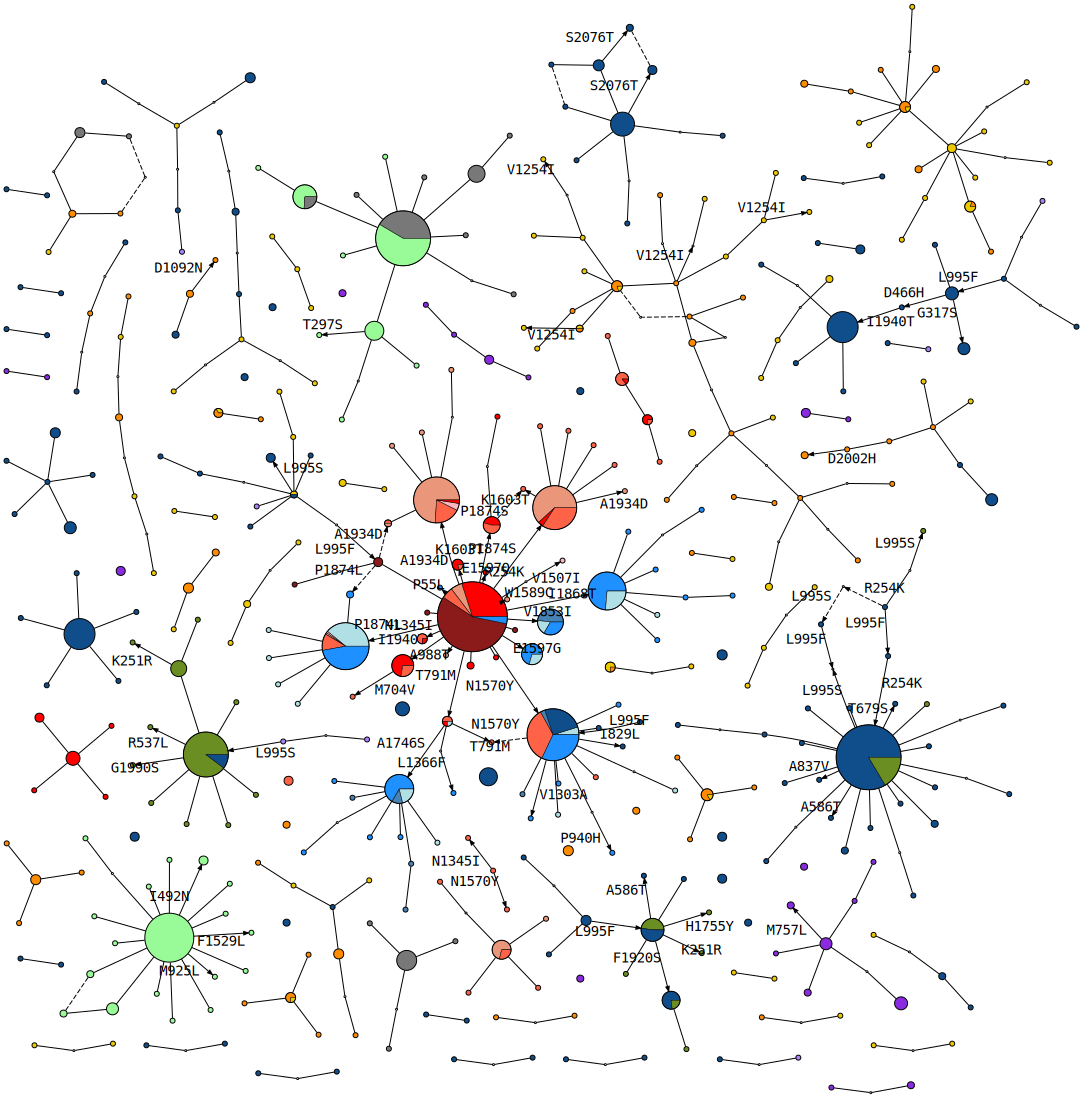

In [18]:
# check network construction works - network all haplotypes
graph, _ = hapclust.graph_haplotype_network(
    h_vgsc, 
    network_method='msn', 
    hap_colors=hap_colors, 
    max_dist= 2, 
    variant_labels=variant_labels,
    show_singletons=False)
graph

In [19]:
# locate haplotypes with resistance alleles
pos_995S = 2422651
pos_995F = 2422652
pos_1527T = 2429617
pos_490I = 2400071
loc_995S = h_vgsc[pos_vgsc.locate_key(pos_995S)] == 1
loc_995F = h_vgsc[pos_vgsc.locate_key(pos_995F)] == 1
loc_1527T = h_vgsc[pos_vgsc.locate_key(pos_1527T)] == 1
loc_490I = h_vgsc[pos_vgsc.locate_key(pos_490I)] == 1

In [20]:
pop_995F = df_haplotypes.population.iloc[loc_995F]
pop_995F.head()

0    GHcol
1    GHcol
2    GHcol
3    GHcol
4    GHcol
Name: population, dtype: object

In [21]:
pop_995F.value_counts()

CMgam    312
BFgam    184
AOcol    131
CIcol    130
BFcol    128
GHcol     90
GNgam     80
GAgam     45
GHgam     24
GNcol      7
Name: population, dtype: int64

In [22]:
pop_995S = df_haplotypes.population.iloc[loc_995S]
pop_995S.head()

468    UGgam
469    UGgam
470    UGgam
471    UGgam
472    UGgam
Name: population, dtype: object

In [23]:
pop_995S.value_counts()

UGgam    224
CMgam     93
GAgam     93
KE        73
Name: population, dtype: int64

In [24]:
pop_1527T = df_haplotypes.population.iloc[loc_1527T]
pop_1527T.value_counts()

BFcol    20
GHcol    19
CIcol    12
GNcol     1
Name: population, dtype: int64

In [25]:
pop_490I = df_haplotypes.population.iloc[loc_490I]
pop_490I.value_counts()

KE    18
GM     4
Name: population, dtype: int64

In [26]:
np.count_nonzero(loc_995F), np.count_nonzero(loc_995S), np.count_nonzero(loc_1527T), np.count_nonzero(loc_490I)

(1131, 483, 52, 22)

In [27]:
# resistance haps
h_vgsc_995F = h_vgsc.compress(loc_995F, axis=1)
h_vgsc_995S = h_vgsc.compress(loc_995S, axis=1)
h_vgsc_1527T = h_vgsc.compress(loc_1527T, axis=1)
h_vgsc_490I = h_vgsc.compress(loc_490I, axis=1)

In [28]:
# colours
hap_colors_995F = hap_colors.compress(loc_995F)
hap_colors_995S = hap_colors.compress(loc_995S)
hap_colors_1527T = hap_colors.compress(loc_1527T)
hap_colors_490I = hap_colors.compress(loc_490I)

In [29]:
# original haplotype indices - will need these for cluster correspondence
hap_ixs_995F = hap_ixs.compress(loc_995F)
hap_ixs_995S = hap_ixs.compress(loc_995S)
hap_ixs_1527T = hap_ixs.compress(loc_1527T)
hap_ixs_490I = hap_ixs.compress(loc_490I)


## 995F networks

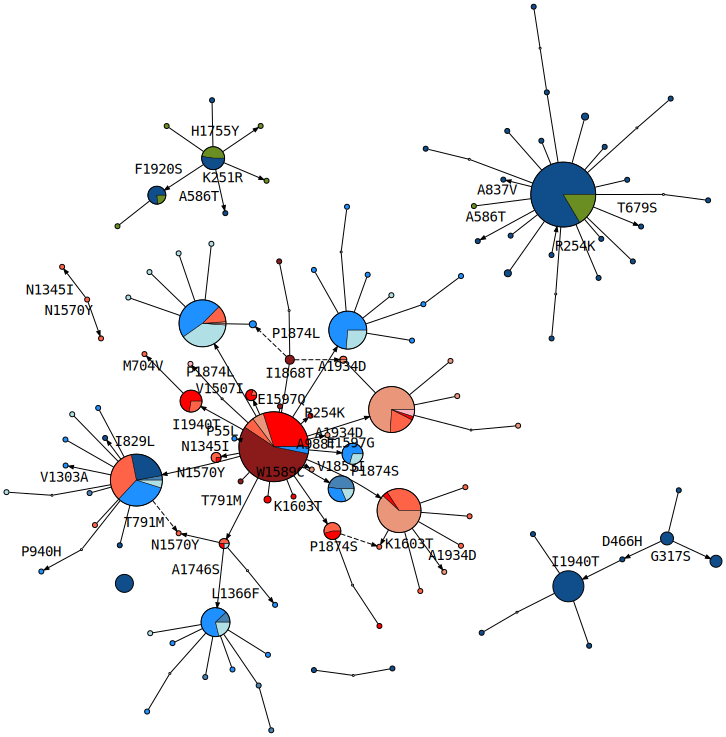

In [30]:
graph_995F, h_distinct_sets_995F, components_995F = hapclust.graph_haplotype_network(
    h_vgsc_995F, 
    network_method='mjn', 
    max_dist=2, 
    hap_colors=hap_colors_995F, 
    variant_labels=variant_labels,
    return_components=True,  # new option, N.B., changes return values
    show_singletons=False,  # new option, don't show unconnected singleton nodes, makes graph less noisy
)
graph_995F.format = 'svg'
fn = '../artwork/995F_clusters_mjn_maxdist2'
graph_995F.render(fn)
graph_995F

In [31]:
# this tells you, for each *distinct* haplotype (i.e., node in the graph), 
# which "connected component" (i.e., cluster) it belongs to
components_995F

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  1,  0,  2,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  2,  2,  3,  0,  0,  0,  0,  0,  0,  0,  4,
        0,  0,  0,  5,  6,  0,  7,  8,  9,  7, 10,  5, 10,  7,  5, 11,  5,
       10, 12, 13, 14,  7, 11, 15, 16, 17, 18, 19,  7, 20,  5, 21,  5, 22,
       23, 10,  5, 24, 25, 26,  5, 27,  5,  5, 28, 29,  5, 30,  7,  7,  5,
        5, 31,  5, 32, 33,  7,  5, 34, 35, 36, 37,  5,  5, 38,  5, 39, 40,
        0,  5,  5, 41,  5, 42,  0,  0, 43, 44, 45,  0, 46, 47, 48, 49,  0,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,  5, 10, 10, 10, 10,
        0,  0,  0,  0,  0,  0,  0,  0, 62,  0, 63, 64,  0, 65,  0,  0, 66,
       67,  0,  0,  0], dtype=int32)

In [32]:
# this tells you the number of distinct haplotypes for each connected component
# e.g., component 0 has 51 *distinct* haplotypes (= 51 nodes in the graph)
# e.g., component 8 has 18 *distinct* haplotypes (= 18 nodes in the graph)
np.bincount(components_995F)

array([69,  1,  3,  1,  1, 22,  1,  8,  1,  1,  8,  2,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [33]:
def identify_components(h_distinct_sets, components):
    """This function is designed to collect all indices for original haplotypes 
    within each connected component. I.e., it finds clusters from the network."""
    clusters = []
    for c in np.unique(components):
        cluster = set()
        for i in np.nonzero(components == c)[0]:
            cluster |= h_distinct_sets[i]
        clusters.append(sorted(cluster))
    return clusters

In [34]:
network_clusters_995F = identify_components(h_distinct_sets_995F, components_995F)
len(network_clusters_995F)

68

In [35]:
len(network_clusters_995F[0])

770

# here we compare the median joining with hierarchical clustering 
- needs the hierarchical clusters to be named 

In [36]:
# load up hierarchical clustering results from previous analysis
hierarchical_cluster_membership = np.load('../data/hierarchical_cluster_membership.npy').astype('U')
hierarchical_clusters = {('other' if not k else k): set(np.nonzero(hierarchical_cluster_membership == k)[0]) 
                         for k in np.unique(hierarchical_cluster_membership)}
for k in sorted(hierarchical_clusters):
    print(repr(k), len(hierarchical_clusters[k]))

'F1' 775
'F2' 14
'F3' 40
'F4' 66
'F5' 191
'S1' 118
'S2' 100
'S3' 177
'S4' 38
'S5' 43
'other' 722


In [37]:
len(hierarchical_clusters['F1'])

775

In [38]:
# setup to quantify overall concordance
network_cluster_membership = np.full_like(hierarchical_cluster_membership, fill_value='')
network_cluster_membership[loc_995F] = 'FX'
network_cluster_membership[loc_995S] = 'SX'

In [39]:
def find_concordance_995F(nc_ix, hc):
    
    # network cluster, mapped back to original haplotype indices
    network_cluster = set(hap_ixs_995F.take(network_clusters_995F[nc_ix]))
    
    # find intersection
    hierarchical_cluster = hierarchical_clusters[hc]
    n_isec = len(hierarchical_cluster.intersection(network_cluster))

    # outputs
    print(repr(hc), n_isec, len(hierarchical_cluster), len(network_cluster), 
          '{:.1f}% concordance'.format(n_isec * 100 / len(hierarchical_cluster)))
    
    # assign
    network_cluster_membership[list(network_cluster)] = hc

In [40]:
# find the network components with more than 2 haplotypes - should be 6
for i, l in enumerate(network_clusters_995F):
    if len(l) > 2:
        print(i, len(l))

0 770
2 3
5 187
7 55
10 40
14 13


In [41]:
pop_995F.iloc[network_clusters_995F[0]].value_counts()

BFgam    183
CIcol    125
BFcol    123
AOcol    111
GHcol     90
GNgam     80
CMgam     28
GHgam     24
GNcol      6
Name: population, dtype: int64

In [42]:
find_concordance_995F(0, 'F1')

'F1' 770 775 770 99.4% concordance


In [43]:
pop_995F.iloc[network_clusters_995F[5]].value_counts()

CMgam    159
GAgam     28
Name: population, dtype: int64

In [44]:
find_concordance_995F(5, 'F5')

'F5' 187 191 187 97.9% concordance


In [45]:
pop_995F.iloc[network_clusters_995F[10]].value_counts()

CMgam    23
GAgam    17
Name: population, dtype: int64

In [46]:
find_concordance_995F(10, 'F4')

'F4' 40 66 40 60.6% concordance


In [47]:
pop_995F.iloc[network_clusters_995F[7]].value_counts()

CMgam    55
Name: population, dtype: int64

In [48]:
find_concordance_995F(7, 'F3')

'F3' 40 40 55 100.0% concordance


In [49]:
pop_995F.iloc[network_clusters_995F[14]].value_counts()

CMgam    13
Name: population, dtype: int64

In [50]:
find_concordance_995F(14, 'F2')

'F2' 13 14 13 92.9% concordance


In [51]:
# compute nucleotide diversity within clusters
is_accessible = phase2_ar1.accessibility['2L/is_accessible'][:]
is_accessible_vgsc = is_accessible[region_vgsc.loc0]
n_bp_accessible_vgsc = np.count_nonzero(is_accessible_vgsc)
n_bp_accessible_vgsc

31809

In [52]:
def compute_pi_995F():
    for i, s in enumerate(network_clusters_995F):
        if len(s) >= 3:
            h = h_vgsc_995F.take(s, axis=1)
            ac = h.count_alleles(max_allele=1)
            mpd = allel.mean_pairwise_difference(ac)
            pi = np.sum(mpd) / n_bp_accessible_vgsc
            print(i, pi)
            
compute_pi_995F()

0 4.4697560431330686e-05
2 4.191685791233089e-05
5 9.739866760032726e-06
7 3.679368638971267e-05
10 2.4102193299590263e-05
14 0.0


## 995S networks

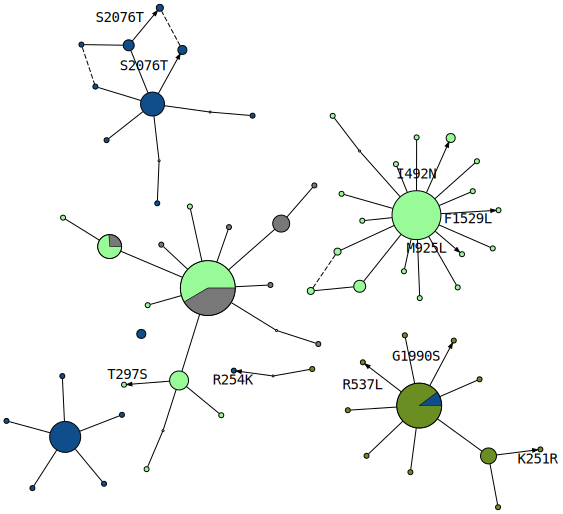

In [53]:
graph_995S, h_distinct_sets_995S, components_995S = hapclust.graph_haplotype_network(
    h_vgsc_995S, 
    network_method='mjn', 
    max_dist=2, 
    hap_colors=hap_colors_995S, 
    variant_labels=variant_labels,
    return_components=True,  # new option, N.B., changes return values
    show_singletons=False,  # new option, don't show unconnected singleton nodes, makes graph less noisy
)
graph_995S.format = 'svg'
fn = '../artwork/995S_clusters_mjn_maxdist2'
graph_995S.render(fn)
graph_995S

In [54]:
network_clusters_995S = identify_components(h_distinct_sets_995S, components_995S)
for i, l in enumerate(network_clusters_995S):
    if len(l) > 2:
        print(i, len(l))

0 117
1 177
5 42
6 37
7 3
9 97


In [55]:
def find_concordance_995S(nc_ix, hc):
    
    # network cluster, mapped back to original haplotype indices
    network_cluster = set(hap_ixs_995S.take(network_clusters_995S[nc_ix]))
    
    # find intersection
    hierarchical_cluster = hierarchical_clusters[hc]
    n_isec = len(hierarchical_cluster.intersection(network_cluster))

    # outputs
    print(repr(hc), n_isec, len(hierarchical_cluster), len(network_cluster), 
          '{:.1f}% concordance'.format(n_isec * 100 / len(hierarchical_cluster)))
    
    # assign
    network_cluster_membership[list(network_cluster)] = hc

In [56]:
find_concordance_995S(0, 'S1')

'S1' 117 118 117 99.2% concordance


In [57]:
find_concordance_995S(1, 'S3')

'S3' 177 177 177 100.0% concordance


In [58]:
find_concordance_995S(6, 'S4')

'S4' 37 38 37 97.4% concordance


In [59]:
find_concordance_995S(5, 'S5')

'S5' 42 43 42 97.7% concordance


In [60]:
find_concordance_995S(9, 'S2')

'S2' 97 100 97 97.0% concordance


In [61]:
# overall concordance
# for the comparison we ignore the FX and SX classes which are not output from the hierarchical clustering
network_cluster_membership_compare = network_cluster_membership.copy()
network_cluster_membership_compare[network_cluster_membership == 'FX'] = ''
network_cluster_membership_compare[network_cluster_membership == 'SX'] = ''
np.count_nonzero(hierarchical_cluster_membership == network_cluster_membership_compare) * 100 / len(hierarchical_cluster_membership)

98.16112084063047

In [62]:
np.unique(hierarchical_cluster_membership)

array(['', 'F1', 'F2', 'F3', 'F4', 'F5', 'S1', 'S2', 'S3', 'S4', 'S5'],
      dtype='<U2')

In [63]:
np.unique(network_cluster_membership)

array(['', 'F1', 'F2', 'F3', 'F4', 'F5', 'FX', 'S1', 'S2', 'S3', 'S4',
       'S5', 'SX'], dtype='<U2')

In [64]:
np.unique(network_cluster_membership_compare)

array(['', 'F1', 'F2', 'F3', 'F4', 'F5', 'S1', 'S2', 'S3', 'S4', 'S5'],
      dtype='<U2')

In [65]:
def compute_pi_995S():
    for i, s in enumerate(network_clusters_995S):
        if len(s) >= 3:
            h = h_vgsc_995S.take(s, axis=1)
            ac = h.count_alleles(max_allele=1)
            mpd = allel.mean_pairwise_difference(ac)
            pi = np.sum(mpd) / n_bp_accessible_vgsc
            print(i, pi)
            
compute_pi_995S()

0 1.5241651473427127e-05
1 2.1515490434584328e-05
5 7.485153198630516e-06
6 3.030475538256355e-05
7 0.0
9 1.2720902111280831e-05


## 1527T

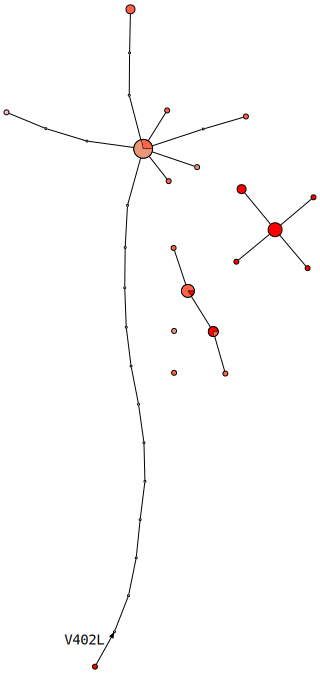

In [66]:
graph_1527T, h_distinct_sets_1527T, components_1527T = hapclust.graph_haplotype_network(
    h_vgsc_1527T, 
    network_method='mjn', 
    max_dist=15, 
    hap_colors=hap_colors_1527T, 
    variant_labels=variant_labels,
    return_components=True,  # new option, N.B., changes return values
    show_singletons=True,  # new option, don't show unconnected singleton nodes, makes graph less noisy
)
graph_1527T.format = 'svg'
fn = '../artwork/1527_clusters_mjn_maxdist2'
graph_1527T.render(fn)
graph_1527T

In [85]:
components_1527T

array([0, 0, 0, 1, 0, 1, 2, 0, 2, 2, 2, 1, 2, 2, 1, 3, 2, 4, 2],
      dtype=int32)

In [67]:
variant_labels[2042]

'I1527T'

In [68]:
network_clusters_1527T = identify_components(h_distinct_sets_1527T, components_1527T)
for i, l in enumerate(network_clusters_1527T):
    if len(l) > 0:
        print(i, len(l))

0 14
1 13
2 23
3 1
4 1


In [69]:
h_vgsc_1527T[2042]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int8)

In [70]:
h_vgsc_1527T[2042, network_clusters_1527T[0]]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8)

In [71]:
h_vgsc_1527T[2042, network_clusters_1527T[1]]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8)

In [72]:
h_vgsc_1527T[2042, network_clusters_1527T[2]]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1], dtype=int8)

In [73]:
h_vgsc_1527T[2042, network_clusters_1527T[3]]

array([1], dtype=int8)

In [74]:
h_vgsc_1527T[2042, network_clusters_1527T[4]]

array([1], dtype=int8)

So three main network components, one for each of the two V402L alternate alleles.

In [75]:
network_cluster_membership[loc_1527T] = 'L1'

## 490I

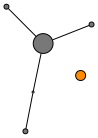

In [76]:
graph_490I, h_distinct_sets_490I, components_490I = hapclust.graph_haplotype_network(
    h_vgsc_490I, 
    network_method='mjn', 
    max_dist=15, 
    hap_colors=hap_colors_490I, 
    variant_labels=variant_labels,
    return_components=True,  # new option, N.B., changes return values
    show_singletons=True,  # new option, don't show unconnected singleton nodes, makes graph less noisy
)
graph_490I.format = 'svg'
fn = '../artwork/490_clusters_mjn_maxdist2'
graph_490I.render(fn)
graph_490I

In [77]:
network_cluster_membership[loc_490I] = 'L2'

In [78]:
np.save('../data/median_joining_network_membership.npy', network_cluster_membership)

In [79]:
collections.Counter(network_cluster_membership).most_common()

[('F1', 770),
 ('', 596),
 ('F5', 187),
 ('S3', 177),
 ('S1', 117),
 ('S2', 97),
 ('FX', 66),
 ('F3', 55),
 ('L1', 52),
 ('S5', 42),
 ('F4', 40),
 ('S4', 37),
 ('L2', 22),
 ('SX', 13),
 ('F2', 13)]

## Wt diversity

In [80]:
def compute_wt_diversity(pop):

    loc_pop = (df_haplotypes.population == pop).values 
    loc_pop.shape

    h_vgsc_wt_pop = h_vgsc.compress(~loc_995S & ~loc_995F & ~loc_1527T & loc_pop, axis=1)

    ac = h_vgsc_wt_pop.count_alleles(max_allele=1)
    mpd = allel.mean_pairwise_difference(ac)
    pi = np.sum(mpd) / n_bp_accessible_vgsc

    return h_vgsc_wt_pop.shape, pi

In [81]:
compute_wt_diversity('CMgam')

((2092, 189), 0.0014303862331618428)

In [82]:
compute_wt_diversity('GW')

((2092, 182), 0.005660531791205742)

In [83]:
compute_wt_diversity('BFcol')

((2092, 2), 0.003175201986859065)

In [84]:
compute_wt_diversity('AOcol')

((2092, 25), 0.0033061921678350986)